In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here

env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from datasets import load_dataset, Dataset
import pandas as pd

# Load the Lex Fridman podcast dataset
lex_dataset = load_dataset("RamAnanth1/lex-fridman-podcasts", split="train")

# Convert to pandas DataFrame for easier manipulation
lex_df = lex_dataset.to_pandas()

# The dataset only has "title" and "text" fields, so no grouping is needed
# If there is an "id" or similar, we can keep it, but otherwise just keep title and text
lex_video_df = lex_df[["title", "captions"]].copy()
lex_video_df = lex_video_df.rename(columns={"captions": "text"})
lex_video_df["video_id"] = lex_video_df.index.astype(str)


# Convert back to HuggingFace Dataset
video_dataset = Dataset.from_pandas(lex_video_df, preserve_index=False)
video_dataset


Dataset({
    features: ['title', 'text', 'video_id'],
    num_rows: 319
})

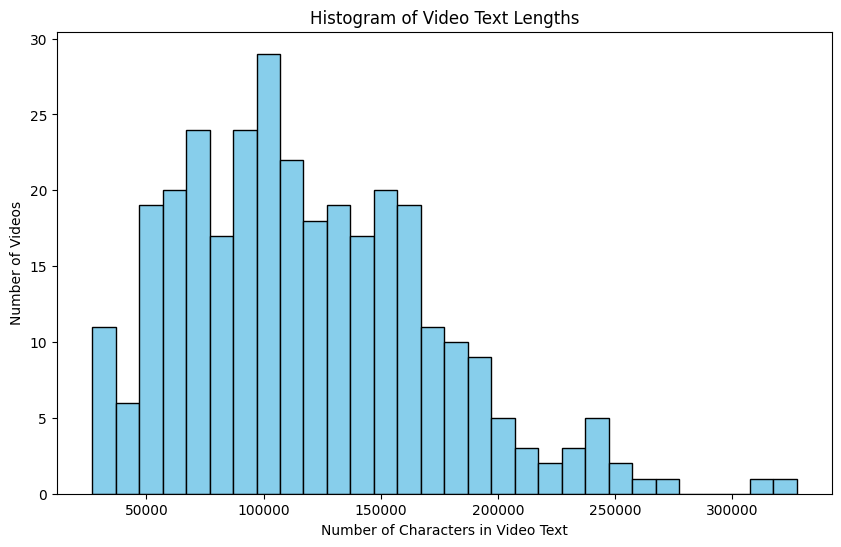

In [3]:
import matplotlib.pyplot as plt

# Compute lengths of each video's text
video_lengths = [len(video['text']) for video in video_dataset]

plt.figure(figsize=(10, 6))
plt.hist(video_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Video Text Lengths")
plt.xlabel("Number of Characters in Video Text")
plt.ylabel("Number of Videos")
plt.show()


In [8]:
# Only keep rows in video_dataset with text length < 200000
video_dataset = video_dataset.filter(lambda x: len(x['text']) < 200000)
print(f'Length of video_dataset: {len(video_dataset)}')

Filter:   0%|          | 0/297 [00:00<?, ? examples/s]

Length of video_dataset: 297


In [73]:
model_name= "anthropic/claude-sonnet-4"
model_name= "meta-llama/llama-4-scout"


In [ ]:
from openai import OpenAI
from os import getenv

client = OpenAI(  
    # using openrouter.ai to access LLMs from several providers
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)
def summarize_text(text, model_name):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes text in full paragraphs using full sentences without missing any important information."},
            {"role": "user", "content": f"Summarize the following text in as many paragraphs as you need. Capture as much of the text as possible in the summary:\n\n{text}\n\nSummary:"}
        ],
        temperature=1,
    )
    return response

In [75]:
from tqdm import tqdm
all_summaries = []

print(f'Length of all_summaries: {len(all_summaries)}')

Length of all_summaries: 0


In [76]:
# Example usage with video_dataset:
summary_response = summarize_text(video_dataset[0]['text'], model_name=model_name)
summary = summary_response.choices[0].message.content
print("Summary:", summary)

for key, value in summary_response.usage.__dict__.items():
    print(key, value)


Summary: The conversation is between the host and Max Tegmark, a professor at MIT and co-founder of the Future of Life Institute. Max Tegmark is a physicist who has spent a large part of his career studying the mysteries of the cosmological universe, but he has also delved into the beneficial possibilities and existential risks of artificial intelligence. He has written two books, "Our Mathematical Universe" and "Life3.0", which are highly recommended by the host.

The host and Max Tegmark discuss the possibility of intelligent life existing elsewhere in the universe. Max Tegmark expresses his minority view that he doesn't think there's intelligent life out there somewhere else in the universe. He cites the Fermi paradox, which questions why we haven't encountered any signs of intelligent life elsewhere in the universe. Max Tegmark believes that if intelligent life were common, we would have seen some sign of it by now, such as radio signals or other evidence of technology.

The conver

In [77]:
print(f'Using model {model_name}')
for idx, video in tqdm(enumerate(video_dataset), desc="Summarizing videos", total=len(video_dataset)):
    if idx < len(all_summaries):
        continue
    try:
        summary_response = summarize_text(video['text'], model_name=model_name)
        summary = summary_response.choices[0].message.content
        all_summaries.append(dict(
                video_id=video['video_id'], title=video['title'],
                summary=summary, total_tokens=summary_response.usage.total_tokens, 
                prompt_tokens=summary_response.usage.prompt_tokens, completion_tokens=summary_response.usage.completion_tokens,
                ))
    except Exception as e:
        print(f"Error summarizing video {video['video_id']}: {e}")
        continue


Using model meta-llama/llama-4-scout


Summarizing videos:   0%|          | 0/297 [00:00<?, ?it/s]

Summarizing videos: 100%|██████████| 297/297 [13:15<00:00,  2.68s/it]


In [78]:
# Convert all_summaries to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(all_summaries)
df.head()


,video_id,title,summary,total_tokens,prompt_tokens,completion_tokens
0,0,Max Tegmark: Life 3.0 | Lex Fridman Podcast #1,The conversation between the host and Max Tegm...,15988,15399,589
1,1,Christof Koch: Consciousness | Lex Fridman Pod...,The conversation begins with a discussion abou...,12816,12164,652
2,2,Steven Pinker: AI in the Age of Reason | Lex F...,The conversation begins with a discussion on t...,7630,6942,688
3,3,Yoshua Bengio: Deep Learning | Lex Fridman Pod...,The conversation revolves around the differenc...,7588,6872,716
4,4,Vladimir Vapnik: Statistical Learning | Lex Fr...,"Vladimir Vapnik, a renowned computer scientist...",8146,7507,639


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import re

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a sentence transformer model from HuggingFace
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
model = SentenceTransformer(EMBEDDING_MODEL, trust_remote_code=True)

In [80]:
all_similarities = []
verbose = False
# Define the specific regex pattern for timestamps
timestamp_pattern = r'(\[\d{2}:\d{2}:\d{2} - \d{2}:\d{2}:\d{2}\])'
# define regex to split by sentence
sentence_pattern = r'(?<=[.!?])\s+'

# Iterate over each video in the video_dataset
for idx, video in tqdm(enumerate(video_dataset), total=len(video_dataset), desc="Calculating similarities"):
    video_id = video['video_id']
    video_title = video['title']
    original_text = video['text']
    # Find the summary for this video_id in df
    summary_row = df[df['video_id'] == video_id]
    if summary_row.empty:
        print(f"Summary for video_id {video_id} not found.")
        continue
    summary = summary_row.iloc[0]['summary']

    # Chunk into sentences using the specific timestamp pattern
    chunks_A = re.split(sentence_pattern, original_text)
    JOIN_CHUNK_A_SIZE = 10  # join sentences to make chunks_A larger
    chunks_A = [' '.join(chunks_A[i:i+JOIN_CHUNK_A_SIZE]) for i in range(0, len(chunks_A), JOIN_CHUNK_A_SIZE)]
    if verbose:
        print(f'Original words: {len(original_text.split(' '))}. Original chunk size: {len(chunks_A)}')
    chunks_B = re.split(sentence_pattern, summary)  # output of prompt is a summary
    if verbose:
        print(f'Summary words: {len(summary.split(' '))}. Summary chunk size: {len(chunks_B)}')
    try:
        # Get embeddings
        A_embeds = model.encode(chunks_A, convert_to_numpy=True)
        B_embeds = model.encode(chunks_B, convert_to_numpy=True)
        # For each sentence in chunks_B, get cosine similarity to all sentences in chunks_A
        similarities = cosine_similarity(B_embeds, A_embeds)
        all_similarities.append(similarities)
    except Exception as e:
        print(f"Error embedding video {video_id}: {e}")
        continue


Calculating similarities: 100%|██████████| 297/297 [20:25<00:00,  4.13s/it]   


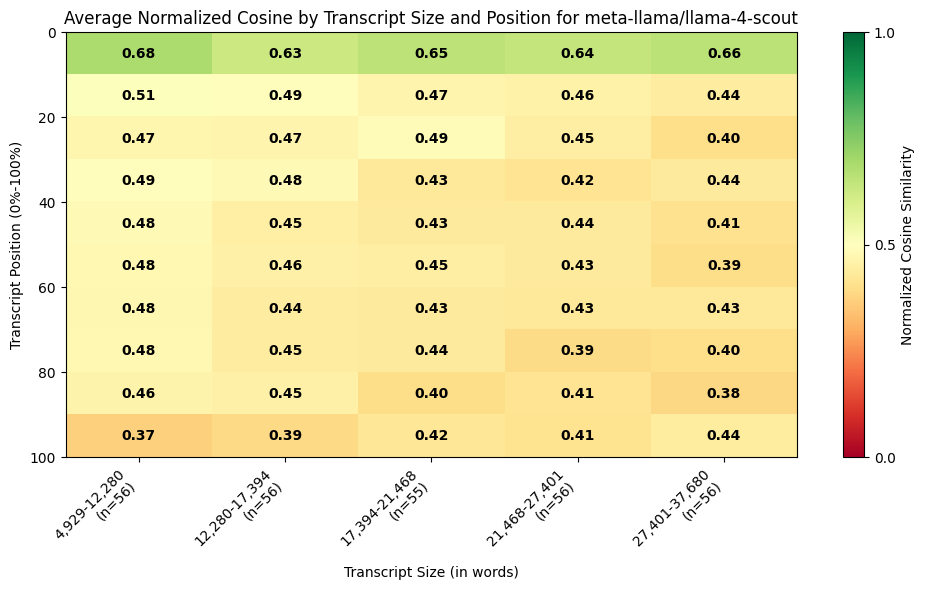

In [81]:
# Bucket videos by their original text length and average similarities within each bucket
import math

# Number of buckets (default 5)
n_buckets = 5

# Get original text length for each video (from df, which has 'text' and 'video_id')
# Build a mapping from video_id to prompt token count (original text length)
video_id_to_prompt_tokens = {v['video_id']: v['text'].count(' ') + 1 for v in video_dataset if int(v['video_id']) in df['video_id']}

# Build a list of (video, text_length, similarity) only for videos that have both text_length and similarity
valid_video_info = []
for i, video in enumerate(video_dataset):
    video_id = video['video_id']
    prompt_tokens = video_id_to_prompt_tokens.get(video_id, None)
    # Only include if prompt_tokens is not None and similarity exists for this index
    if prompt_tokens is not None and i < len(all_similarities):
        similarity = all_similarities[i]
        valid_video_info.append((video, prompt_tokens, similarity))

if not valid_video_info:
    print("No valid videos with both prompt token counts and similarities.")
    # Optionally, exit or skip the rest of the code
else:
    valid_video_dataset = [v[0] for v in valid_video_info]
    valid_prompt_token_counts = [v[1] for v in valid_video_info]
    valid_similarities = [v[2] for v in valid_video_info]

    # Sort by prompt token count for quantile bucketing
    sorted_indices = np.argsort(valid_prompt_token_counts)

    sorted_prompt_tokens = np.array(valid_prompt_token_counts)[sorted_indices]
    sorted_video_dataset = [valid_video_dataset[i] for i in sorted_indices]
    sorted_similarities = [valid_similarities[i] for i in sorted_indices]

    # Compute bucket edges for equal-sized buckets (quantiles)
    total = len(sorted_prompt_tokens)
    bucket_indices = []
    bucket_edges = []
    for b in range(n_buckets):
        start_idx = int(round(b * total / n_buckets))
        end_idx = int(round((b + 1) * total / n_buckets))
        bucket_indices.append(list(range(start_idx, end_idx)))
        if end_idx > 0:
            bucket_edges.append(sorted_prompt_tokens[start_idx])
    # Add the last edge
    bucket_edges.append(sorted_prompt_tokens[-1])

    # For each video, compute normalized similarity vector (as before)
    norm_similarities_list = []
    for similarities in sorted_similarities:
        avg_similarities = np.max(similarities, axis=0)  # shape: (len(chunks_A),)
        norm_similarities_list.append(avg_similarities)

    # To average, we need to interpolate all similarity vectors to the same length (e.g., 100 points)
    interp_len = 10
    norm_similarities_interp = []
    for norm_sim in norm_similarities_list:
        x_old = np.linspace(0, 1, len(norm_sim))
        x_new = np.linspace(0, 1, interp_len)
        norm_sim_interp = np.interp(x_new, x_old, norm_sim)
        norm_similarities_interp.append(norm_sim_interp)

    # Now, for each bucket, average the interpolated similarities
    bucket_avg_similarities = []
    bucket_counts = []
    for b in range(n_buckets):
        idxs = bucket_indices[b]
        if idxs:
            arrs = [norm_similarities_interp[i] for i in idxs]
            avg_arr = np.mean(arrs, axis=0)
            bucket_avg_similarities.append(avg_arr)
            bucket_counts.append(len(idxs))
        else:
            bucket_avg_similarities.append(np.full(interp_len, np.nan))
            bucket_counts.append(0)

    # Plot: each column is a bucket, y-axis is normalized sentence index (0-100%), color is avg similarity
    fig, ax = plt.subplots(figsize=(2 * n_buckets, 6))
    # Stack columns horizontally: shape (interp_len, n_buckets)
    heatmap_data = np.stack(bucket_avg_similarities, axis=1)  # shape: (interp_len, n_buckets)

    # Set up y-axis scaling (0% at top, 100% at bottom)
    y_start, y_end = 100, 0
    extent = [0, n_buckets, y_start, y_end]

    im = ax.imshow(heatmap_data, aspect='auto', cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Normalized Cosine Similarity', ticks=[0, 0.5, 1])
    ax.set_xticks(np.arange(n_buckets) + 0.5)
    # Label buckets by token range
    bucket_labels = []
    for b in range(n_buckets):
        left = int(bucket_edges[b])
        right = int(bucket_edges[b + 1])
        bucket_labels.append(f"{left:,}-{right:,}\n(n={bucket_counts[b]:,})")
    ax.set_xticklabels(bucket_labels, rotation=45, ha='right')
    ax.set_xlabel('Transcript Size (in words)')
    ax.set_ylabel('Transcript Position (0%-100%)')
    ax.set_title(f'Average Normalized Cosine by Transcript Size and Position for {model_name}')
    plt.ylim(y_start, y_end)
    plt.xlim(0, n_buckets)

    # --- Add numbers in each box for color blind accessibility ---
    # We'll annotate each cell with its value, formatted to 2 decimals
    for i in range(interp_len):
        for j in range(n_buckets):
            
            value = heatmap_data[i, j]
            if not np.isnan(value):
                # Calculate the position in data coordinates
                # x: bucket index + 0.5 (center of bucket)
                # y: normalized sentence index (from y_start to y_end, so invert i)
                x = j + 0.5
                y =  (i + 0.5) * (y_start - y_end) / interp_len
                ax.text(
                    x, y, f"{value:.2f}",
                    ha='center', va='center',
                    color='black',
                    fontsize=10, fontweight='bold'
                )

    plt.tight_layout()
    plt.savefig(f"avg_normalized_cosine_similarity_by_prompt_token_bucket_{model_name.replace('/', '_')}_equal_samples.png", dpi=300)
    plt.show()


Shape of heatmap_data for meta-llama/llama-4-scout: (10, 5)
Data type: float64
Min value: 0.3678571789392403
Max value: 0.6836765754435744
Mean value: 0.46183578170778994
Median value: 0.4445617459123098
Std deviation: 0.07106599558449286
Number of NaNs: 0


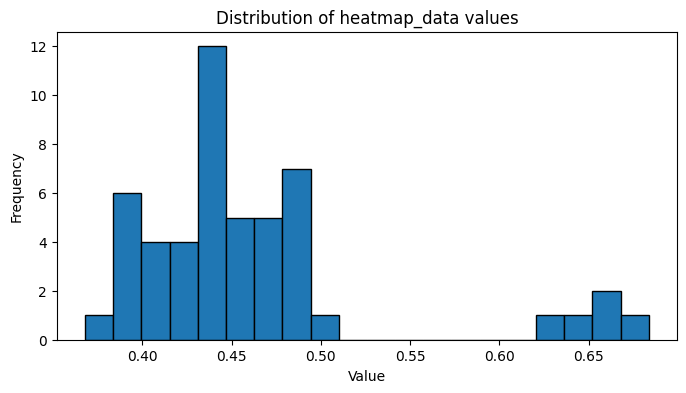

Rows with all NaNs: []
Columns with all NaNs: []


In [82]:
# Exploratory Data Analysis (EDA) of heatmap_data

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Basic info
print(f"Shape of heatmap_data for {model_name}:", heatmap_data.shape)
print("Data type:", heatmap_data.dtype)

# Summary statistics
print("Min value:", np.nanmin(heatmap_data))
print("Max value:", np.nanmax(heatmap_data))
print("Mean value:", np.nanmean(heatmap_data))
print("Median value:", np.nanmedian(heatmap_data))
print("Std deviation:", np.nanstd(heatmap_data))
print("Number of NaNs:", np.isnan(heatmap_data).sum())

# Distribution of values (flattened, ignoring NaNs)
flat_vals = heatmap_data.flatten()
flat_vals = flat_vals[~np.isnan(flat_vals)]
plt.figure(figsize=(8,4))
plt.hist(flat_vals, bins=20, edgecolor='black')
plt.title("Distribution of heatmap_data values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


# Check for any rows or columns with all NaNs
nan_rows = np.where(np.all(np.isnan(heatmap_data), axis=1))[0]
nan_cols = np.where(np.all(np.isnan(heatmap_data), axis=0))[0]
print("Rows with all NaNs:", nan_rows)
print("Columns with all NaNs:", nan_cols)

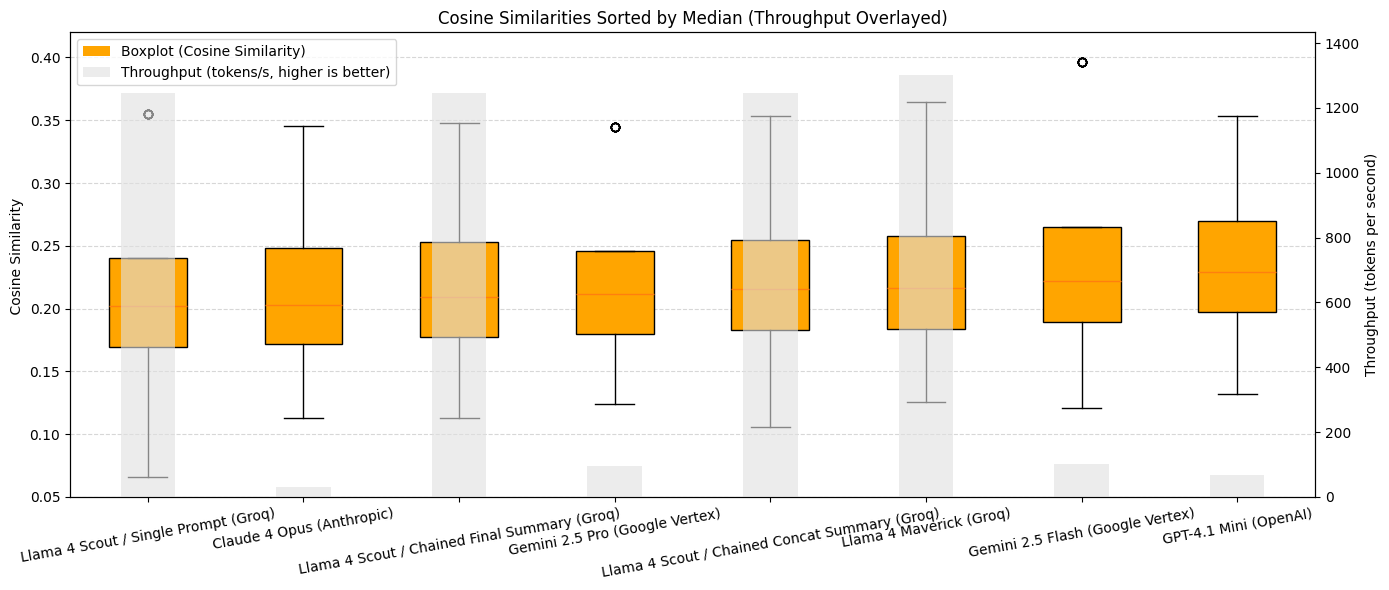

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

box_data = pd.DataFrame({
    'normal': [0.065503, 0.169438, 0.202146, 0.240616, 0.354568],
    'chunked_summary': [0.105789, 0.182838, 0.215918, 0.254257, 0.353580],
    'summary': [0.112675, 0.177658, 0.209444, 0.252795, 0.347696],
    'Gemini 2.5 Flash': [0.121201, 0.189634, 0.222109, 0.264694, 0.396401],
    'Gemini 2.5 Pro': [0.123952, 0.180095, 0.211641, 0.245719, 0.344413],
    'GPT-4.1 Mini': [0.131832, 0.197458, 0.229383, 0.269400, 0.353170],
    'Claude 4 Opus': [0.112783, 0.171961, 0.203136, 0.248506, 0.345588],
    'Llama 4 Maverick': [0.125650, 0.183441, 0.216616, 0.257577, 0.364696]
}, index=['min', 'q1', 'median', 'q3', 'max']).T

label_map = {
    'normal': 'Llama 4 Scout / Single Prompt (Groq)',
    'summary': 'Llama 4 Scout / Chained Final Summary (Groq)',
    'chunked_summary': 'Llama 4 Scout / Chained Concat Summary (Groq)',
    'Gemini 2.5 Flash': 'Gemini 2.5 Flash (Google Vertex)',
    'Gemini 2.5 Pro': 'Gemini 2.5 Pro (Google Vertex)',
    'GPT-4.1 Mini': 'GPT-4.1 Mini (OpenAI)',
    'Claude 4 Opus': 'Claude 4 Opus (Anthropic)',
    'Llama 4 Maverick': 'Llama 4 Maverick (Groq)'
}

# Throughput values unchanged
throughput_map = {
    'Llama 4 Scout / Single Prompt (Groq)': 1245,
    'Llama 4 Scout / Chained Final Summary (Groq)': 1245,
    'Llama 4 Scout / Chained Concat Summary (Groq)': 1245,
    'Gemini 2.5 Flash (Google Vertex)': 102,
    'Gemini 2.5 Pro (Google Vertex)': 96,
    'GPT-4.1 Mini (OpenAI)': 69,
    'Claude 4 Opus (Anthropic)': 30,
    'Llama 4 Maverick (Groq)': 1303
}

# Sort by median
box_data['median'] = box_data['median']
sorted_box_data = box_data.sort_values(by='median')

# Simulate data from quantiles
simulated_data = [
    [row['min']] * 10 + [row['q1']] * 65 + [row['median']] * 147 +
    [row['q3']] * 65 + [row['max']] * 10
    for _, row in sorted_box_data.iterrows()
]

sorted_labels = [label_map.get(label, label) for label in sorted_box_data.index]
throughputs = [throughput_map.get(label, np.nan) for label in sorted_labels]

fig, ax1 = plt.subplots(figsize=(14, 6))

x = np.arange(1, len(sorted_labels) + 1)
box = ax1.boxplot(simulated_data, positions=x, patch_artist=True, showfliers=True, widths=0.5, zorder=2)

for patch in box['boxes']:
    patch.set_facecolor('#FFA500')

ax1.set_xticks(x)
ax1.set_xticklabels(sorted_labels, rotation=10)
ax1.set_ylabel('    Cosine Similarity')
ax1.set_ylim(0.05, 0.42)
ax1.set_title('Cosine Similarities Sorted by Median (Throughput Overlayed)')
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Throughput (tokens per second)')
ax2.set_ylim(0, max(throughputs) * 1.1)

throughput_color = '#e0e0e0'

# Add padding between bars for separation and visual clarity
bar_width = 0.35  # less than boxplot width for padding

# Draw bars with hatching for throughput
bars = ax2.bar(
    x, throughputs, width=bar_width, color=throughput_color, alpha=0.6, zorder=0, align='center',
    label='Throughput (tokens/s, higher is better)',
)

# Dummy plot for legend
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='#FFA500', label='Boxplot (Cosine Similarity)'),
    Patch(facecolor=throughput_color, alpha=0.6, label='Throughput (tokens/s, higher is better)')
]
ax2.legend(handles=legend_handles, loc='upper left')

plt.tight_layout()
plt.savefig("prompt_strategy_sorted_by_median_orange_with_throughput_scaled_axes.png", dpi=300)
plt.show()
